# NB03 — TVSum Preprocessing & Splits

**Goal**: Standardize the temporal resolution to **2 FPS** and create a single "Consensus Truth" from 20 annotators.

### Preprocessing Strategy:
1. **Sampling**: Sample frames at a fixed interval of **0.5 seconds** (2 FPS) regardless of source video FPS.
2. **Aggregation**: Take the mean of all 20 annotators for each 2-second shot.
3. **Alignment**: Replicate the shot-level consensus score across the 4 frames that fall within that shot (since 2s / 0.5s = 4).
4. **Splits**: Category-aware 80/20 split (4 train / 1 val per category).

In [7]:
import pandas as pd
import numpy as np
from pathlib import Path
import json
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import random

# Environment detection
IS_KAGGLE = Path("/kaggle/input").exists()

if IS_KAGGLE:
    # User-specified Kaggle paths
    INDEX_PATH = Path("/kaggle/input/tvsum-index/tvsum_index.csv")
    ANNO_PATH = Path("/kaggle/input/tvsum50-video-summarization/data/ydata-tvsum50-anno.tsv")
else:
    # Local relative paths
    INDEX_PATH = Path("data/processed/tvsum_index.csv")
    ANNO_PATH = Path("data/raw/ydata-tvsum50-anno.tsv")

PROCESSED_DIR = Path("data/processed")
SPLIT_DIR = PROCESSED_DIR / "splits"
SPLIT_DIR.mkdir(parents=True, exist_ok=True)

assert INDEX_PATH.exists(), f"CRITICAL: Video index missing at {INDEX_PATH}"
assert ANNO_PATH.exists(), f"CRITICAL: Annotations missing at {ANNO_PATH}"

print(f"Environment: {'Kaggle' if IS_KAGGLE else 'Local'}")
print(f"Using Index: {INDEX_PATH}")

Environment: Kaggle
Using Index: /kaggle/input/tvsum-index/tvsum_index.csv


## 1. Load Data & Consensus Calculation

In [8]:
index_df = pd.read_csv(INDEX_PATH)

# Load all 1000 rows (20 per video)
anno_df = pd.read_csv(ANNO_PATH, sep="\t", header=0, names=["video_id", "cat_code", "scores"])

def get_consensus_scores(df_vid):
    """Calculates mean normalized scores (0-1) from all annotators for a video."""
    all_scores = []
    for s in df_vid.scores:
        arr = np.fromstring(s, sep=",")
        if arr.size == 0:
             raise ValueError(f"Malformed annotation row for vid: {df_vid.video_id.iloc[0]}")
        all_scores.append(arr)
        
    matrix = np.vstack(all_scores)
    mean_scores = matrix.mean(axis=0)
    norm_scores = (mean_scores - 1) / 4.0
    return norm_scores.astype(np.float32)

consensus_map = {}
for vid_id, group in anno_df.groupby("video_id"):
    consensus_map[str(vid_id)] = get_consensus_scores(group)

print(f"Calculated consensus for {len(consensus_map)} videos.")

Calculated consensus for 50 videos.


## 2. Temporal Sampling & Alignment (2 FPS)

We sample every 0.5s and align it to the 2s shot scores.

In [9]:
SAMPLE_FPS = 2.0
INTERVAL = 1.0 / SAMPLE_FPS  # 0.5s

frame_index_rows = []
target_rows = []

for _, row in tqdm(index_df.iterrows(), total=len(index_df)):
    vid_id = str(row.video_id)
    dur = row.duration_sec
    fps = row.fps
    
    if vid_id not in consensus_map:
        continue
        
    consensus_vec = consensus_map[vid_id]
    
    # --- THE ALIGNMENT FIX ---
    # Mismatch check: Is the number of scores consistent with 2-second shots or frame-level?
    # If (len * 2) >> dur, it means each score is for a frame (~1/30s), not a shot (2s).
    ratio = len(consensus_vec) / dur
    if ratio > 10: 
        mode = "frame"
    else:
        mode = "shot"
    
    timestamps = np.arange(0, dur, INTERVAL)
    
    for i, t in enumerate(timestamps):
        if mode == "shot":
            # Standard: 1 score every 2 seconds
            mapping_idx = int(t // 2)
        else:
            # High-Res: 1 score for every original frame
            mapping_idx = int(round(t * fps))
            
        # Safety clamp
        if mapping_idx >= len(consensus_vec):
            mapping_idx = len(consensus_vec) - 1
            
        score = consensus_vec[mapping_idx]
        
        frame_index_rows.append({
            "video_id": vid_id, "frame_idx": i, "timestamp_sec": round(t, 3)
        })
        target_rows.append({
            "video_id": vid_id, "frame_idx": i, "importance_score": score
        })

frame_index_df = pd.DataFrame(frame_index_rows)
targets_df = pd.DataFrame(target_rows)

print(f"Generated {len(frame_index_df)} sampled frame entries.")

  0%|          | 0/50 [00:00<?, ?it/s]

Generated 25190 sampled frame entries.


## 3. Category-Aware Stratified Splits

We ensure the validation set has exactly one video from each of the 10 categories.

In [10]:
random.seed(42)
train_ids = []
val_ids = []

for cat, group in index_df.groupby("category"):
    vids = group.video_id.tolist()
    random.shuffle(vids)
    val_ids.extend(vids[:1])
    train_ids.extend(vids[1:])

with open(SPLIT_DIR / "tvsum_train.txt", "w") as f:
    f.write("\n".join(map(str, sorted(train_ids))))
with open(SPLIT_DIR / "tvsum_val.txt", "w") as f:
    f.write("\n".join(map(str, sorted(val_ids))))

print(f"Split Complete: {len(train_ids)} Train / {len(val_ids)} Val.")

Split Complete: 40 Train / 10 Val.


## 4. Final Serialization

We save in Parquet format for high-speed I/O in the training loop.

In [11]:
frame_index_df.to_parquet(PROCESSED_DIR / "tvsum_frame_index.parquet")
targets_df.to_parquet(PROCESSED_DIR / "tvsum_targets.parquet")
print("Indexing and Targets saved to data/processed/ in Parquet format.")

Indexing and Targets saved to data/processed/ in Parquet format.


## 5. Verification Visuals

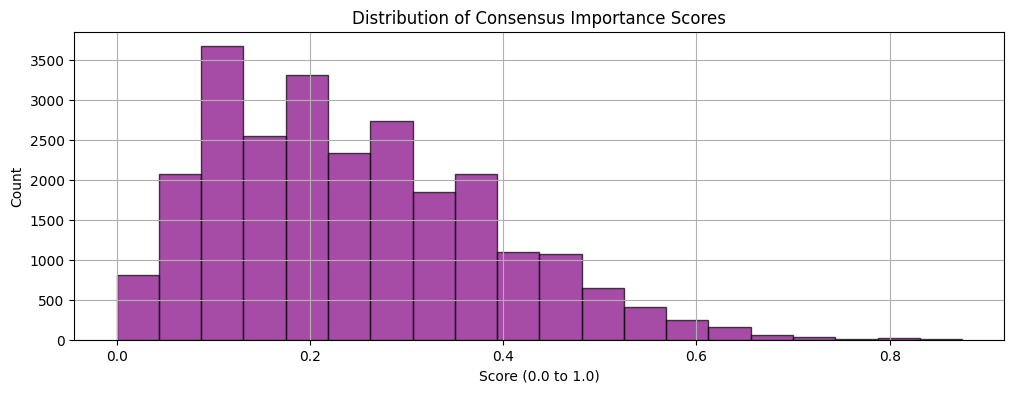

NB03 complete.


In [12]:
plt.figure(figsize=(12, 4))
targets_df.importance_score.hist(bins=20, color='purple', alpha=0.7, edgecolor='black')
plt.title("Distribution of Consensus Importance Scores")
plt.xlabel("Score (0.0 to 1.0)")
plt.ylabel("Count")
plt.show()

print("NB03 complete.")